In [40]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
from Kildekode._10_Konvolusjon import *

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Introduction to FIR filters and convolution

* **AIS2201 - Signal Processing**
* **Uke 42, 2024**
* **Related reading materials:**
    * Chapter 5.1 & 5.2 in Understanding Digital Signal Processing
* **Lecturerer: Kai Erik Hoff**

# Tema:
* Signal og System
* Digitale Filtre - hva og hvorfor?
* Bruk av digitale filtre



# Topics

* Filter as a concept
* Desired properties (LTI)
* Discrete LTI-systems (the difference equation)
* Physical systems and IIR filters
    * Digital IIR filters created by discretizing continuous systems
    * Exponential averager is a IIR filter
* FIR filters
    * Coefficients = impulse response
    * Filtering = convolving impulse respone & signal

# What is a filter?

* In a signal processing context:
    * Attenuates unwanted frequency components in a signal
    * Amplifies/preserves desired frequency components in a signal

<img src="Figurer/10_Digitale Filtre Intro/FilterIllustration.png" style="margin-left:15%" width="60%"/>

# Desirable properties


* Sinusoid in $\Rightarrow$ sinusoid out
    * Basic requirement for frequency analysis of a system
    * Inherent to the definition of a filter

* Frequency components affected *independently*
    * A lowpass filter should attenuate high-frequency components regardless of whether a low-frequency component is present in the signal as well.

* The above conditions require the digital filter to be ***Linear*** and ***Time-Invariant***

# Linearity

* Given $y[n] = F(x[n])$, where $F$ denotes the system's function, the system described by $F$ is linar if it satisfies the following conditions:

    * **Additivity:**
    $$F(x_1[n] + x_2[n]) = F(x_1[n])+F(x_2[n])$$
    
    * **Homogeneity:**
    $$F(\alpha \cdot x[n]) = \alpha \cdot F(x[n])$$

## Linearity Illustrated:

<img src="Figurer/10_Digitale Filtre Intro/Fig7_Additivity_v2.png" style="width: 50%" />

# Time-Invariance


* Given $y[n] = F(x[n])$ where $F$ denotes the system's function, adding a delay to the input should produce the same delay at the output:
$$F(x[n-N]) = y[n-N]$$
<br>
<img src="Figurer/10_Digitale Filtre Intro/Fig8_TimeInv.png" style="width: 60%" />

# Digital LTI-systems

* Composed of a limited set of linear and time-invariant mathematical operations:

#### Summation
<div style="width:80%">
<img src="Figures/fir_filters/summation.png" style="float:right; width:20%"/>
$$y[n] = x_1[n] \pm x_2[n]$$     
</div>

#### Scalar multiplication
<div style="width:80%">
<img src="Figures/fir_filters/multiply.png" style="float:right; width:20%"/>
$$y[n] = x[n] \cdot \alpha$$     
</div>

#### Delay (time shifting)
<div style="width:80%">
<img src="Figures/fir_filters/delay.png" style="float:right; width:20%"/>
$$y[n] = x[n-1]$$     
</div>

# Final requirement: causality

* Filter output may not depend on future sample values

* Essential for real-time systems
  
<img src="Figurer/10_Digitale Filtre Intro/Fig5_FilterAnimation.gif" width="40%"  />

* Filters retroactively processing recorded data may be non-causal

# Discrete-time Causal LTI-systems:

* Described using a ***difference equation***
$$\sum_{k=0}^{M} a_k \cdot y[n-k] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$
    * The series $a_k$ and $b_k$ are known as *filter coefficients*

# Filter categories

### **I**nfinite **I**mpulse **R**esponse (IIR)
* Uses previous values of both input $x[n-k]$ and output $y[n-k]$ as basis for calculating the updated output value $y[n]$.
* General algorithm for IIR filters:

$$y[n] = \frac{1}{a_0}\cdot \left(\sum_{k=0}^{N} b_k \cdot x[n-k] - \sum_{k=1}^{M}a_k\cdot  y[n-k] \right)$$

### **F**inite **I**mpulse **R**esponse (FIR)
* Uses *only* previous input values $x[n-k]$ as a basis for calculating
* General algorithm for FIR filtrs:
$$y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

# IIR filter system diagram

<img src="Figures/fir_filters/df1.png" style="margin-left:25%;width:50%"/>

* Filter order: $\max(M, N)$
    * *How many samples into the past does the IIR filter need to "remember"*

## Example of a IIR filter: *exponential averager*

* The output is a weighted sum of the current input $x[n]$ and the previous output $y[n-1]$:
$$y[n] = \alpha \cdot x[n] + (1-\alpha) \cdot y[n-1]$$

(0.0, 127.0)

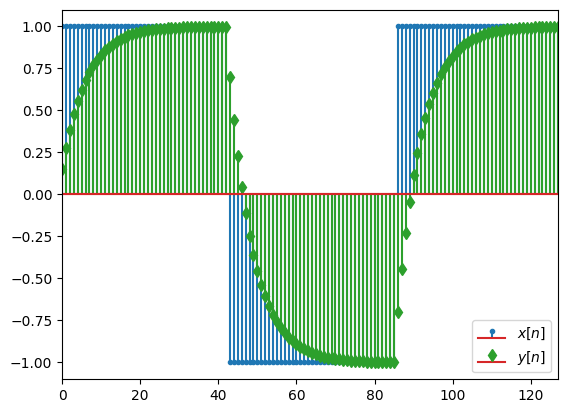

In [7]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt 
def exponential_averaging(x: np.ndarray, alpha=0.1):
    """
    Function to perform exponential averaging on an input signal 'x'. 
    Filtering function: y[n] = alpha*x[n] + (1-alpha)*y[n-1]

    Parameters:
    - x: Array representing input signal
    - alpha: Smoothing factor 0 < alpha < 1

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)  # length of signal
    y = np.zeros(L)
    for n in range(L):
        y[n] = alpha*x[n] + (1-alpha)*y[n-1]
    return y


N = 128
n = np.arange(N)
xn = sig.square(2*np.pi*1.5*n/N)
yn = exponential_averaging(xn, alpha=0.15)

plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="d", linefmt="C2", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

# Designing IIR filters

1. Determine desired filter response (lowpass/highpass etc...)

In [9]:
f_c = 100 # Cutoff frequency (Hz)
filter_type = "lowpass" 

2. Design an *analog* filter (butterworth, chebyshev, bessel etc...) with the desired response

Text(0, 0.5, 'Filter gain (dB)')

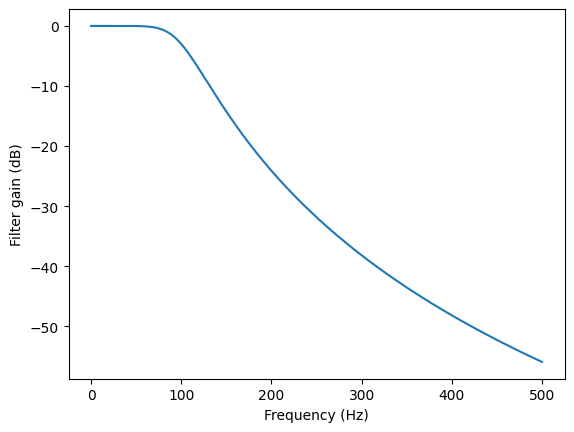

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
b, a = sig.butter(4, f_c*2*np.pi, filter_type, analog=True)
w, Hw = sig.freqs(b, a, worN=np.pi*2*np.linspace(0, 500, 513))
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)")

3. *Discretize* the analog filter, typically using Tustin's method (aka. Bilinear Transform) with pre-warping.
    * *Tustin's method is preferred for DSP applications because it allows us to retain corner frequencies precisely*

(-100.0, 12.005490853061767)

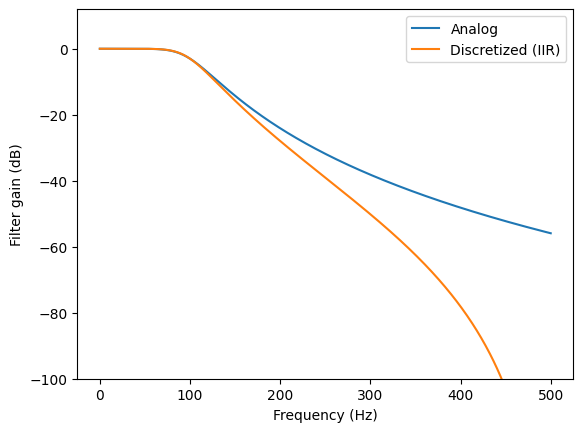

In [36]:
import matplotlib.pyplot as plt
import numpy as np
fs = 1_000 # samples / second
fs_warped = (np.pi*f_c)/np.tan(np.pi*f_c/fs)  # Pre-warping
b_d, a_d = sig.bilinear(b, a, fs=fs_warped)
f_d, Hf_d = sig.freqz(b_d, a_d, fs=fs)
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)), label="Analog")
plt.plot(f_d, 20*np.log10(np.abs(Hf_d)), label="Discretized (IIR)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)"); plt.ylim(ymin=-100)

Mathematically, an IIR filter is identical to a discrete controller or a discretized system model. The only difference is mathematical notation, and the domain of application (the discrete controller is inserted into a closed loop, while the terminology "IIR filter" typically refers to a stand-alone "open-loop" system for filtering e.g. music).

Since the theory behind IIR filters and discrete control theory is the same, IIR filters will not play a major role in this course's curriculum. If you wish a refresher, chapter 6 covers this topic in detail.

# What is a FIR filter?

* **FIR** - **F**inite **I**mpulse **R**esponse
* Describes a digital filter which calculates the output $y[n]$ based *only* on a linear combination of the input values $x[n]$ at various samplingtimes.
* Entirely described by the filter coefficients $b_k$
* Can be viewed as a Discrete LTI-system where $a_k$ equals:
$$
a_k = 
\begin{cases}
1,\ \ \  k = 0\\
0,\ \ \  k \neq 0
\end{cases}
$$

* Difference exuation for FIR filters:
### $$ y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

* $N$ denotes the *filter order*
    * Determines how many samples "back in time" the FIR filter needs to keep samples in the buffer.

# FIR filter system diagram

<img src="Figures/fir_filters/Fig13_FIR_struct.png" style="width: 60%" />

* FIR filters commonly referred to as *tapped delay line* filters
* Number of "taps" ($M=N+1$) are a more common metric for size of filter than the filter order

## Example of a FIR filter: *moving average filter*
* The output $y[n]$ is the ***mean*** of the $M$ most recent input values $x[n-k], k \in \{0, 1, \ldots , M-1\}$.

$$y[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]$$



(0.0, 127.0)

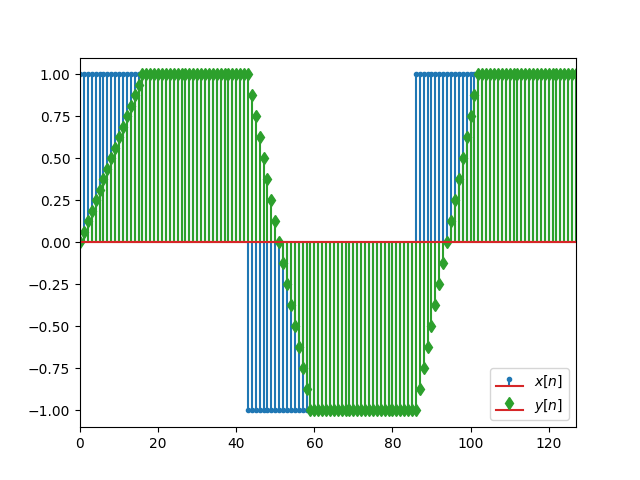

In [43]:
def exponential_averaging(x: np.ndarray, K=16):
    """
    Function to perform moving average filtering of an input signal 'x'.
    Filtering function: y[n] = (x[n] + x[n-1] + ... + x[n-K+1])/K

    Parameters:
    - x: Array representing input signal
    - K: Length of averaging "window"

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)
    y = np.zeros(L)
    for n in range(L):
        y[n] = np.sum(x[max(n-K, 0):n])/K
    return y


N = 128
n = np.arange(N)
xn = sig.square(2*np.pi*1.5*n/N)
yn = exponential_averaging(xn, K=16)

plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="d", linefmt="C2", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

## Question:

* What are the filter coefficients $b_k$ of a $M=8$-tap moving average filter?

# FIR filter 

More intricate designs of FIR filters involve analyzing/shaping the *Impulse Response* of the FIR filter.

# Digital filter properties: *The Impulse Response*

<img src="Figurer/10_Digitale Filtre Intro/Fig10_hn.png" style="width: 60%; margin-left: 200px%" />

* The mathematical properties of a digital filter which is both linear and time-invariant are contained entirely within it's impulse response.
* Calculating the impulse response of an IIR filter is highly cumbersome, so the impulse response is rarely relevant for analyzing IIR filters.
* The impulse response of a FIR filter is easily acquired...
<!--
* Premiss for LTI-system:
    * *Dersom systemets reaksjon til en deltapuls $\delta[n]$ er kjent, er det mulig å predikere hvordan systemet vil reagere på alle mulige inngangssignal.*
* Utgangssignalet til et LTI-system gitt en impuls $\delta[n]$ som inngangssignal kalles impulsresponsen $h[n]$ til systemet.
-->

# FIR filters impulse response

\begin{align}
h[n] &= \sum_{k=0}^{M} b_k \cdot \delta[n-k]\\
     &= b_0 \cdot \delta[n] + b_1\cdot \delta[n-1] + \ldots + b_M\cdot \delta[n-M]\\
     &= b_k \big|_{k=n}, 0 \leq n \leq M
\end{align}

* The impulse response of a FIR filter is a signal which contains each filter coefficient $b_k$ in turn.

<img src="Figurer/10_Digitale Filtre Intro/Fig11_FIR.png" style="width: 80%; margin-left: 100px%" />

## Question
* What is the impulse respone $h[n]$ of an 8-point moving average filter?

# Why the impulse response $h[n]$ of a filter is important


1. Any signal can be decomposed into a sum of scaled and shifted deltapulses.

$$x[n] = \sum_{k=0}^{\infty} x[k] \cdot \delta[n-k]$$



2. The properties of *linearity* and *time-invariance* imply that the ouputput of a LTI-system can be expressed as a sum of scaled and shifted *impulse responses*.
\begin{align}
y[n] &= F(x[n])\\
     &= F\left(\sum_{k=-\infty}^{\infty} x[k]\cdot \delta[n-k]\right)\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot F(\delta[n-k])\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]
\end{align}

# Convolution

* Utgangssignalet til et LTI-system utregnes ved å utføre ***konvolusjon*** av inngangssignalet $x[n]$ og impulsresponsen $h[n]$.
    * Konvolusjon har en egen matematisk operator: $*$.

\begin{align}
y[n] &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]\\
&= x[n]*h[n]
\end{align}

## Demo: Filtrering av signal med konvolusjon

Output()

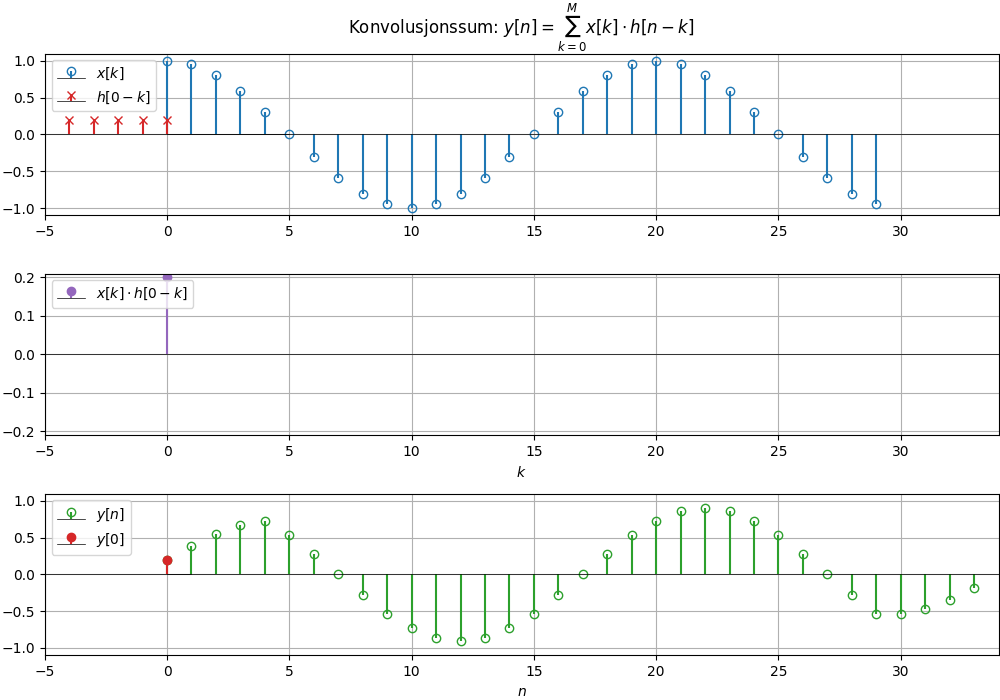

In [41]:
from Kildekode._10_Konvolusjon import convolutionDemo
n = np.arange(30); xn = np.cos(pi/10*n) # Sinussekvens
hn = np.array(np.ones(5)/5)                      # 
convolutionDemo(xn, hn, fig_num=2,figsize=(10,7));    #